# Exploring Neural Operators Package

## Example 1: A simple Darcy-Flow dataset

In [7]:
import matplotlib.pyplot as plt
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.layers.embeddings import GridEmbedding2D
import urllib.request
import os

In [8]:
def download(
    url : str,
    local_filename : str = None
):
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

base_url = 'https://www.github.com/neuraloperator/neuraloperator/raw/refs/heads/main/neuralop/data/datasets/data/'
download(os.path.join(base_url, 'darcy_test_32.pt'))
download(os.path.join(base_url, 'darcy_test_16.pt'))
download(os.path.join(base_url, 'darcy_train_16.pt'))

train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=1000, batch_size=32,
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
        data_root='./',
)

device = 'cpu'
data_processor = data_processor.to(device)

train_dataset = train_loader.dataset

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralop\data\datasets\pt_dataset.py:122: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\python_variable_indexing.cpp:312.)
  data["x"][train_input_indices].unsqueeze(channel_dim).type(torch.float32).clone()
c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralop\data\datasets\pt_dataset.py:125: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in

16
Testing samples for res 16 have shape torch.Size([1, 16, 16])
32
Testing samples for res 32 have shape torch.Size([1, 32, 32])
Training samples have shape torch.Size([16, 16])


c:\Users\eamor\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\eamor\AppData\Local\Temp\ipykernel_95404\2688208138.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


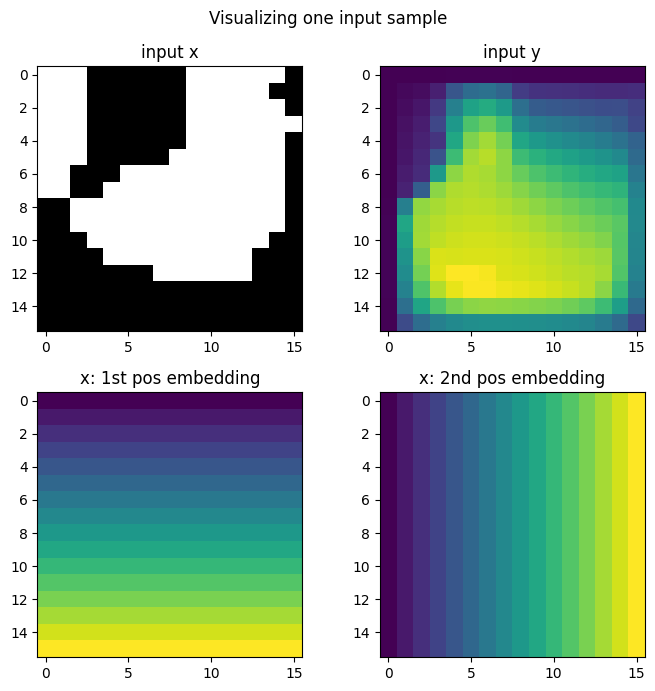

In [ ]:
for res, test_loader in test_loaders.items():
    print(res)
    # Get first batch
    batch = next(iter(test_loader))
    x = batch['x']
    y = batch['y']

    print(f'Testing samples for res {res} have shape {x.shape[1:]}')


data = train_dataset[0]
x = data['x']
y = data['y']

print(f'Training samples have shape {x.shape[1:]}')


# Which sample to view
index = 0

data = train_dataset[index]
data = data_processor.preprocess(data, batched=False)

# The first step of the default FNO model is a grid-based
# positional embedding. We will add it manually here to
# visualize the channels appended by this embedding.
positional_embedding = GridEmbedding2D(in_channels=1)
# at train time, data will be collated with a batch dim.
# we create a batch dim to pass into the embedding, then re-squeeze
x = positional_embedding(data['x'].unsqueeze(0)).squeeze(0)
y = data['y']

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(2, 2, 1)
ax.imshow(x[0], cmap='gray')
ax.set_title('input x')

ax = fig.add_subplot(2, 2, 2)
ax.imshow(y.squeeze())
ax.set_title('input y')

ax = fig.add_subplot(2, 2, 3)
ax.imshow(x[1])
ax.set_title('x: 1st pos embedding')

ax = fig.add_subplot(2, 2, 4)
ax.imshow(x[2])
ax.set_title('x: 2nd pos embedding')

fig.suptitle('Visualizing one input sample', y=0.98)
plt.tight_layout()
fig.show()

these are 4 plots representing the way that positional embeddings work.
- Plot 1: input x
- Plot 2: output y with positional embedding
- Plot 3: first channel of positional embedding (x[1] / x)
- Plot 4: second channel of positional embedding (x[2] / y)

## Example 2: A simple Darcy-Flow spectrum analysis

In [10]:
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from neuralop.utils import spectrum_2d
from neuralop.data.datasets import load_darcy_flow_small

font = {'size'   : 28}
matplotlib.rc('font', **font)

torch.manual_seed(0)
np.random.seed(0)

In [11]:
T = 500 # number of time steps
samples = 50
s = 16 # resolution of the dataset

# additional paramaters for the dataset
Re = 5000
index = 1
T = 100
dataset_name = "Darcy Flow"

In [17]:
def download(
    url : str,
    local_filename : str = None
):
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

base_url = 'https://www.github.com/neuraloperator/neuraloperator/raw/refs/heads/main/neuralop/data/datasets/data/'
download(os.path.join(base_url, 'darcy_test_32.pt'))
download(os.path.join(base_url, 'darcy_test_16.pt'))
download(os.path.join(base_url, 'darcy_train_16.pt'))

train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=50, batch_size=50,
        test_resolutions=[16, 32], n_tests=[50, 50],
        test_batch_sizes=[32],
        encode_output=False,
        data_root='./',
)

device = 'cpu'
data_processor = data_processor.to(device)

# This is highly depending on your dataset and its structure ['x', 'y'] (In Darcy flow)
print("Original dataset shape", train_loader.dataset[:samples]['x'].shape) # check the shape

# It is important to note that we want the last two dimensions to represent the spatial dimensions
# So in some cases one might have to permute the dataset after squeezing the initial dimensions as well
dataset_pred = train_loader.dataset[:samples]['x'].squeeze() # squeeze the dataset to remove the empty channel dimension

# Shape of the dataset
shape = dataset_pred.shape

# Define the grid size - in our case its a 2d Grid repeating, for higher dimensions this will change
# Example for 3d grid
"""
batchsize, size_x, size_y, size_z = 1, shape[0], shape[1], shape[2]
gridx = torch.tensor(np.linspace(-1, 1, size_x), dtype=torch.float)
gridx = gridx.reshape(1, size_x, 1, 1, 1).repeat([batchsize, 1, size_y, size_z, 1])
gridy = torch.tensor(np.linspace(-1, 1, size_y), dtype=torch.float)
gridy = gridy.reshape(1, 1, size_y, 1, 1).repeat([batchsize, size_x, 1, size_z, 1])
gridz = torch.tensor(np.linspace(-1, 1, size_z), dtype=torch.float)
gridz = gridz.reshape(1, 1, 1, size_z, 1).repeat([batchsize, size_x, size_y, 1, 1])
grid = torch.cat((gridx, gridy, gridz), dim=-1)
"""
batchsize, size_x, size_y = 1, shape[1], shape[2]
gridx = torch.tensor(np.linspace(-1, 1, size_x), dtype=torch.float)
gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, size_y])
gridy = torch.tensor(np.linspace(-1, 1, size_y), dtype=torch.float)
gridy = gridy.reshape(1, 1, size_y).repeat([batchsize, size_x, 1])
grid = torch.cat((gridx, gridy), dim=-1)

Loading test db for resolution 16 with 50 samples 
Loading test db for resolution 32 with 50 samples 
Original dataset shape torch.Size([50, 1, 16, 16])


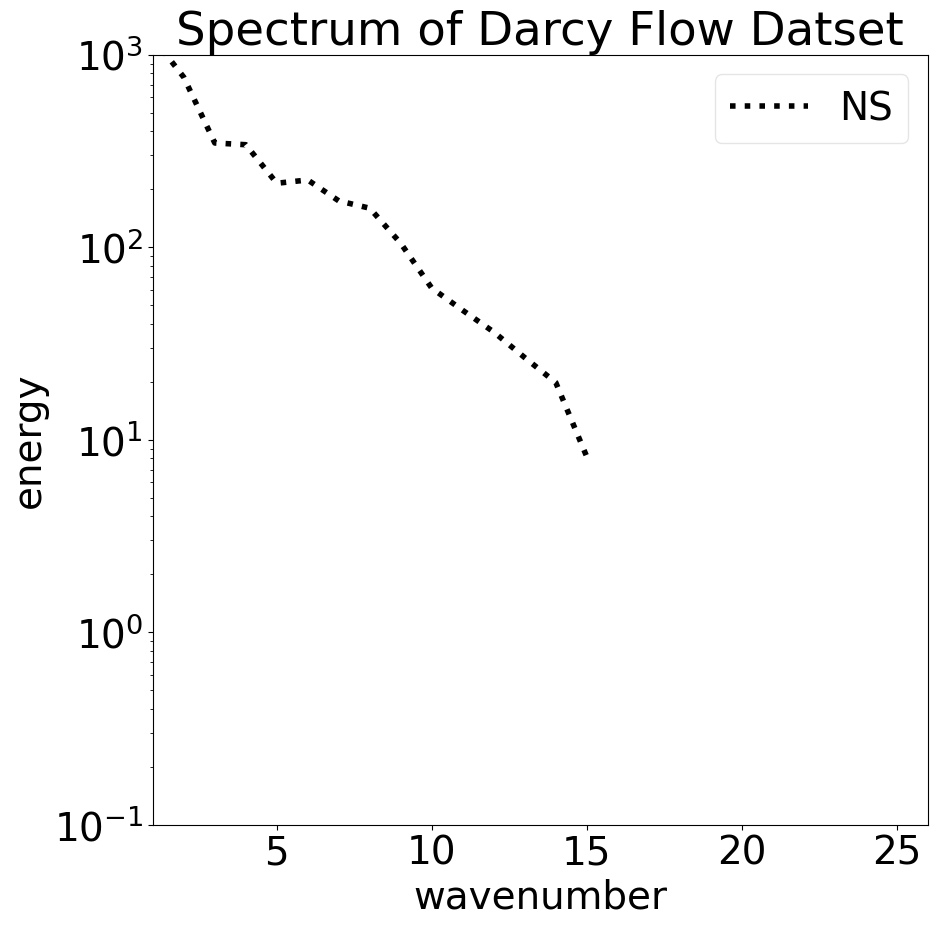

In [19]:
# Generate the spectrum of the dataset
# We reshape our samples into the form expected by ``spectrum_2d``: ``(n_samples, h, w)``
truth_sp = spectrum_2d(dataset_pred.reshape(samples * batchsize, s, s), s)

# Configure pyplot and generate the plot
fig, ax = plt.subplots(figsize=(10,10))

linewidth = 3
ax.set_yscale('log')

length = dataset_pred.shape[-1] # the resolution length of the dataset
buffer = 10 # just add a buffer to the plot
k = np.arange(length + buffer) * 1.0
ax.plot(truth_sp, 'k', linestyle=":", label="NS", linewidth=4)

ax.set_xlim(1,length+buffer)
ax.set_ylim(0.1, 1000)
plt.legend(prop={'size': 20})
plt.title('Spectrum of {} Datset'.format(dataset_name))

plt.xlabel('wavenumber')
plt.ylabel('energy')

# show the figure
leg = plt.legend(loc='best')
leg.get_frame().set_alpha(0.5)
plt.show()

## Example 4: 